
# Customer Segmentation using Clickstream Data

This project aims to segment customers based on their behavior using an e-commerce clickstream dataset. The goal is to identify distinct user groups to enable data-driven marketing and retention strategies.

## Project Workflow
1. **Data Loading & Cleaning**
2. **Feature Engineering**: Creating metrics like views, cart adds, purchases, conversion rate, etc.
3. **Clustering**: Applying K-Means and finding optimal `k`
4. **Dimensionality Reduction**: PCA for visualization
5. **Segment Profiling**: Summarizing and labeling each cluster


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [2]:
df = pd.read_csv("2019-Nov.csv")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2.053010e+18,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2.053010e+18,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2.053010e+18,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2.053010e+18,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2.053010e+18,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [3]:
print("Shape:", df.shape)
df.info()

Shape: (999998, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999998 entries, 0 to 999997
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     999998 non-null  object 
 1   event_type     999998 non-null  object 
 2   product_id     999998 non-null  int64  
 3   category_id    999998 non-null  float64
 4   category_code  683022 non-null  object 
 5   brand          852801 non-null  object 
 6   price          999998 non-null  float64
 7   user_id        999998 non-null  int64  
 8   user_session   999998 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 68.7+ MB


In [4]:
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
df['event_date'] = df['event_time'].dt.date
df['event_hour'] = df['event_time'].dt.hour
df.isnull().sum()
df = df.dropna(subset=['event_time'])


## Feature Engineering Explanation

The following features were engineered from raw event data for each user:
- `views`: Number of product views
- `cart_adds`: Number of cart addition events
- `purchases`: Number of purchase events
- `conversion_rate`: Purchases divided by views
- `cart_to_purchase_ratio`: Purchases divided by cart additions
- `unique_products` and `unique_categories`: Diversity of interest
- `avg_price`: Average price of viewed items
- `sessions`: Distinct user sessions

These features represent user activity and intent, helping us cluster similar behavior patterns.


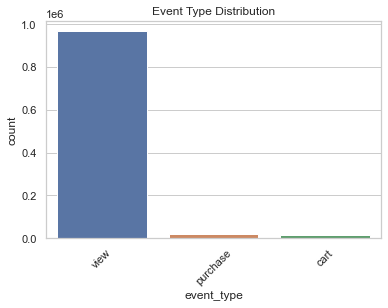

In [5]:
sns.countplot(data=df, x='event_type', order=df['event_type'].value_counts().index)
plt.title("Event Type Distribution")
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:title={'center':'Events per Hour'}, xlabel='event_time'>

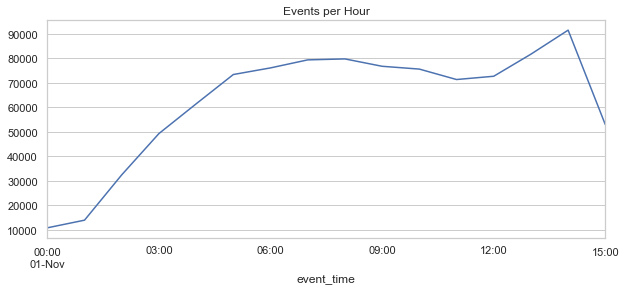

In [6]:
df.set_index('event_time')['event_type'].resample('H').count().plot(
    figsize=(10, 4), title="Events per Hour"
)

In [ ]:
user_features = df.groupby('user_id').agg(
    total_events=('event_type', 'count'),
    views=('event_type', lambda x: (x == 'view').sum()),
    cart_adds=('event_type', lambda x: (x == 'cart').sum()),
    purchases=('event_type', lambda x: (x == 'purchase').sum()),
    unique_products=('product_id', pd.Series.nunique),
    unique_categories=('category_code', pd.Series.nunique),
    sessions=('user_session', pd.Series.nunique),
    avg_price=('price', 'mean')
)

In [ ]:
user_features['conversion_rate'] = user_features['purchases'] / user_features['views']
user_features['cart_to_purchase_ratio'] = user_features['purchases'] / user_features['cart_adds']
user_features = user_features.fillna(0)
user_features.head()

In [17]:
user_features.to_csv("user_behavior_features.csv")
print("Features saved!")

Features saved!


In [7]:
df_new = pd.read_csv("user_behavior_features.csv")
print("NaNs:\n", df_new.isna().sum())
print("\nInfinite values:\n", df_new.isin([float('inf'), float('-inf')]).sum())

NaNs:
 user_id                   0
total_events              0
views                     0
cart_adds                 0
purchases                 0
unique_products           0
unique_categories         0
sessions                  0
avg_price                 0
conversion_rate           0
cart_to_purchase_ratio    0
dtype: int64

Infinite values:
 user_id                      0
total_events                 0
views                        0
cart_adds                    0
purchases                    0
unique_products              0
unique_categories            0
sessions                     0
avg_price                    0
conversion_rate              7
cart_to_purchase_ratio    8243
dtype: int64


In [8]:
df_new.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df_new.fillna(0, inplace=True)

In [9]:
features = df_new.copy()
scaler = StandardScaler()
scaled = scaler.fit_transform(features)


## Clustering Summary

K-Means clustering was applied on scaled features. The optimal number of clusters was determined using the Elbow Method and Silhouette Score.

PCA (Principal Component Analysis) was then used to reduce feature dimensions for 2D visualization of the clusters.


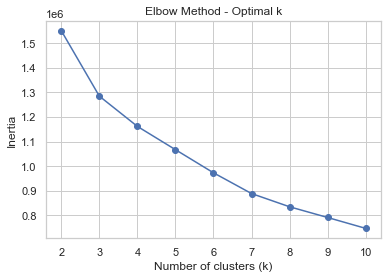

In [10]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [18]:
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled)
    score = silhouette_score(scaled, labels)
    print(f"k={k}, Silhouette Score={score:.3f}")

k=2, Silhouette Score=0.554
k=3, Silhouette Score=0.534
k=4, Silhouette Score=0.226
k=5, Silhouette Score=0.234


In [11]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled)
features.head()

,user_id,total_events,views,cart_adds,purchases,unique_products,unique_categories,sessions,avg_price,conversion_rate,cart_to_purchase_ratio,cluster
0,274969076,3,3,0,0,1,1,2,304.75000,0.0,0.0,0
1,275256741,1,1,0,0,1,1,1,1415.48000,0.0,0.0,0
2,295643776,8,8,0,0,4,2,2,189.94625,0.0,0.0,0
3,296465302,25,25,0,0,23,2,2,221.20800,0.0,0.0,2
4,319315209,3,3,0,0,2,0,1,4.88000,0.0,0.0,0


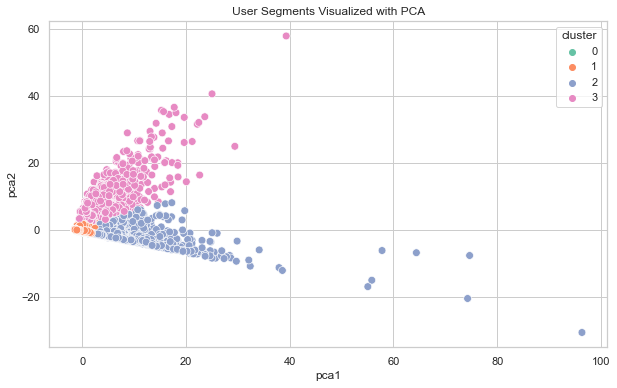

In [20]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled)
features['pca1'] = pca_result[:, 0]
features['pca2'] = pca_result[:, 1]
features['pca3'] = pca_result[:, 2]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='pca1', y='pca2', hue='cluster', palette='Set2', s=60)
plt.title('User Segments Visualized with PCA')
plt.show()

In [23]:
plt.savefig("2d_cluster_plot.png", dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

In [21]:
features.to_csv('user_behaviour_with_cluster.csv')

In [22]:
cluster_summary = features.groupby('cluster').mean().round(2)
cluster_summary

,user_id,total_events,views,cart_adds,purchases,unique_products,unique_categories,sessions,avg_price,conversion_rate,cart_to_purchase_ratio,pca1,pca2,pca3
cluster,,,,,,,,,,,,,,
0,5.195735e+08,4.42,4.36,0.03,0.03,2.89,0.90,1.28,324.86,0.01,0.00,-0.31,-0.25,-0.22
1,5.568612e+08,3.56,3.51,0.02,0.03,2.39,0.84,1.25,305.25,0.01,0.00,-0.57,-0.12,0.24
2,5.340305e+08,29.72,29.46,0.10,0.15,16.90,2.23,2.92,268.90,0.01,0.01,4.85,-1.40,0.05
3,5.394726e+08,8.46,5.72,1.24,1.51,2.62,1.01,1.71,341.59,0.45,0.61,1.59,5.55,-0.03


In [16]:
segment_labels = {
    0: "Passive Browsers",
    1: "Non-Engaged Users",
    2: "Window Shoppers",
    3: "Loyal Buyers"
}
features['segment_label'] = features['cluster'].map(segment_labels)

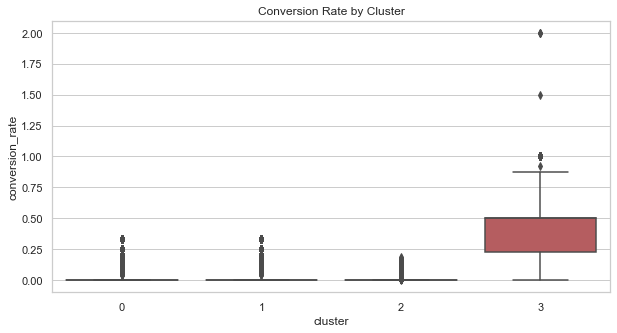

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=features, x='cluster', y='conversion_rate')
plt.title('Conversion Rate by Cluster')
plt.show()


In [15]:
summary_df = features.groupby('segment_label').agg({
    'views': 'mean',
    'purchases': 'mean',
    'conversion_rate': 'mean',
    'sessions': 'mean'
}).round(2)

summary_df

,views,purchases,conversion_rate,sessions
segment_label,,,,
Loyal Buyers,5.72,1.51,0.45,1.71
Non-Engaged Users,3.51,0.03,0.01,1.25
Passive Browsers,4.36,0.03,0.01,1.28
Window Shoppers,29.46,0.15,0.01,2.92



## Segment Profiling

Each cluster was analyzed and labeled based on user behavior metrics. This allows us to attach meaningful business interpretations to each group.

For example:
- **Loyal Buyers**: High purchase and conversion rate
- **Window Shoppers**: High views but low purchases
- **Passive Browsers**: Low interaction overall
- **Non-Engaged Users**: Little to no meaningful activity



## Conclusion

This customer segmentation approach helps businesses understand user behavior and tailor engagement strategies accordingly. The identified clusters offer actionable insights for targeting promotions, improving retention, and increasing overall sales conversion.
